In [ ]:
!pip install umap-learn==0.5.2

In [ ]:
import os
import pandas as pd

new_path = os.path.split(os.getcwd())[0]

import umap.umap_ as umap
import textwrap as twp
from sentence_transformers import SentenceTransformer, util
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt

load and prepare data

In [2]:
bot_general = pd.read_pickle(os.path.join(new_path,'_data','bot_general.pkl'))

In [3]:
bot_general['t1_year'] = pd.to_datetime(bot_general['t1_datetime']).dt.year
bot_general = bot_general[bot_general['t1_year']==2021]
bot_general = bot_general[~bot_general['t1_text_cleaned'].isnull()]
bot_general = bot_general.drop_duplicates('t1_text_cleaned')
bot_general.loc[:,'t1_text_cleaned'] = [t.lower() for t in bot_general['t1_text_cleaned']]
bot_general = bot_general.reset_index(drop=True)

In [4]:
len(bot_general)

763930

embed t1 tweets

In [5]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda:0')

In [6]:
%time corpus_embeddings = model.encode(bot_general['t1_text_cleaned'], batch_size=64, show_progress_bar=True, convert_to_tensor=True)

Batches:   0%|          | 0/11937 [00:00<?, ?it/s]

CPU times: user 1h 27min, sys: 6min 49s, total: 1h 33min 49s
Wall time: 4min 42s


In [ ]:
with open(os.path.join(new_path,'_model','embeddings_t1','embeddings_t1.pkl'), 'wb') as f:
    pickle.dump(corpus_embeddings, f, protocol=pickle.HIGHEST_PROTOCOL)

clustering

In [ ]:
with open(os.path.join(new_path,'_model','embeddings_t1','embeddings_t1.pkl'), 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [7]:
%time clusters = util.community_detection(corpus_embeddings, min_community_size=150, threshold=0.7, batch_size=1024)

CPU times: user 2min 6s, sys: 285 ms, total: 2min 7s
Wall time: 2min 7s


In [8]:
bot_general['cluster'] = None
for i, cluster in enumerate(clusters):
    for id_ in cluster:
        bot_general.loc[id_,'cluster'] = i+1

In [ ]:
bot_general[['t1_id','cluster']].to_pickle(os.path.join(new_path,'_data','_cluster_t1','t1_id_cluster.pkl'))

extract significant tokens per cluster

In [9]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english", token_pattern=r'[^\s]+').fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    return tf_idf, count

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

def create_representative_table(clusters, top_n_words):  
    representative_table = pd.DataFrame({"cluster":[],"text":[]})
    for i, cluster in enumerate(clusters):
        for sentence_id in cluster[0:1]:
                representative_table = pd.concat([representative_table,pd.DataFrame([", ".join([x[0] for x in  top_n_words[i+1]][0:8])], columns=['text'])])
    representative_table["cluster"] = range(1,len(clusters)+1)
    return representative_table

In [10]:
docs_df = bot_general[~bot_general['cluster'].isnull()][['t1_text_cleaned','cluster']].rename(columns={'t1_text_cleaned': 'Doc', 'cluster': 'Topic'})
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs_df))

In [11]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

visualize clustering in 2-dimensional space

In [12]:
plt.rc('axes', unicode_minus=False)

In [13]:
umap_data = umap.UMAP(n_neighbors=20, n_components=2, min_dist=0, metric='cosine').fit_transform(corpus_embeddings.cpu())
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = bot_general['cluster']

In [14]:
cluster_words_df = create_representative_table(clusters, top_n_words)

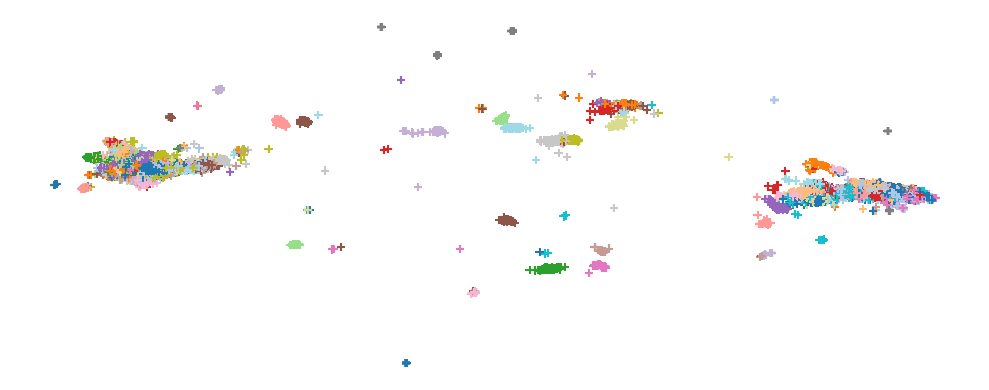

In [15]:
fig, (ax1) = plt.subplots(figsize=(10,4))

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
clustered = result.loc[(result.labels != 1) & (result.labels != 88)  , :]

ax1.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
ax1.scatter(clustered.x, clustered.y, c=clustered.labels, s=35, cmap='tab20',marker="+")
ax1.axis('off')

for i in range(1,len(clusters)+1):
    x = np.median(result[result["labels"]==i]["x"])
    y = np.median(result[result["labels"]==i]["y"])     

plt.tight_layout()
# plt.savefig(os.path.join(new_path,'_results','fig4_t1_clustering.pdf'))
plt.show()